![](11111.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams
import lmfit
import matplotlib.image as mpimg
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from lmfit.models import LorentzianModel

In [2]:
# bokeh packages
from bokeh.io import output_file,show,output_notebook,push_notebook, curdoc
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper, Select, Slider
from bokeh.palettes import Category10
from bokeh.layouts import row,column,gridplot,widgetbox
from bokeh.models.widgets import Tabs,Panel
output_notebook()

Loading BokehJS ...

In [3]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams.update({'font.size': 22})
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['xtick.major.size'] = 10
rcParams['ytick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True

In [35]:
#with subtracting Si
def qz_int(data, dataw, angle):

    #y_pixels=np.arange(-853, 1199)  #center of pixel (-127, 1921)#-853, 1194
    #z_pixels=np.arange(-50, -2102,-1) #-385 1667
    
    #z_pixels1=np.arange(0, -1667,-1) 
    #z_pixels2=np.arange( 385, 0,-1) 
    #z_pixels=np.append(z_pixels1, z_pixels2)
    
    y_pixels=np.arange(-822, 1230)  
    z_pixels=np.arange(-377, 1675) 
    
    #tan(phi)=height/perpendicular     height=pixel_size*y_pixels      perpendicular=distance of dector
    tan_phi=(0.146*y_pixels)/2269.44
    tan_theta_f=(0.146*z_pixels)/(np.sqrt(((0.146 * y_pixels[0])**2)+(2263.44**2)))
    
    ang=angle
    #phi=tan-1(height/perpendicular)
    phi=np.arctan(tan_phi)
    thet_f=np.arctan(tan_theta_f)
    theta_f=thet_f-(ang*np.cos(phi))
    
    
    qx=((2*np.pi)/0.687)*((np.cos(theta_f)*np.cos(phi))-np.cos(ang))
    qy=((2*np.pi)/0.687)*(np.cos(theta_f)*np.sin(phi))
    qz=((2*np.pi)/0.687)*(np.sin(theta_f)+np.sin(ang))
    
    
    samples=[]
    for sample in data:
        sam=np.genfromtxt(sample, delimiter='\t', skip_header=12)
        q_int=np.insert(sam, 0, qz, axis=1)  #adding qz column
        samples.append(q_int)
    samples=np.array(samples)
    
    qz = samples[:,:,0]
    
    samples_w=np.genfromtxt(dataw, delimiter='\t', skip_header=12) #for empty si
    
    I=samples[:,:,2]-samples_w[:,1]   #since adding qz so intensity is in 3 column-samples[:,:,2]
    
    
    color=['white','blue','green','gray','yellow', 'purple']
    
    plt.style.use('dark_background')
    fig, ax= plt.subplots(figsize=(15,10))
    ax.set(ylabel='Intensity', xlabel='Qz(A^-1)')
    for i in range(len(data)):
        ax.plot(qz[i,:],I[i,:], color=color[i],linewidth=3,label=data[i][1:4])
    ax.legend()
    #ax.set_xlim([-0.9, 0])
    #ax.set_ylim([0.007, 100])
    ax.set_yscale('log')
    figname=data[1][1:3]
    plt.title('GSAXS for ' + str(figname) +' at angle =' +str(angle)+ ' with Si subtraction')
    #return plt.savefig(figname)
    plt.show()

In [36]:
#without subtracting si
def qz_int_ws(data, angle):
    y_pixels=np.arange(863, 2915)  #center of pixel (-127, 1921)#-853, 1194
    z_pixels=np.arange(-210, -2262,-1) #-385 1667
    #tan(phi)=height/perpendicular
    #height=pixel_size*y_pixels
    #perpendicular=distance of dector
    tan_phi=(0.146*y_pixels)/2269.44
    tan_theta_f=(0.146*z_pixels)/(np.sqrt(((0.146 * y_pixels)**2)+(2263.44**2)))
    #phi=tan-1(height/perpendicular)
    phi=np.arctan(tan_phi)
    theta_f=np.arctan(tan_theta_f)
    
    ang=angle*(np.pi/180)
    qx=((2*np.pi)/0.687)*((np.cos(theta_f)*np.cos(phi))-np.cos(ang))
    qy=((2*np.pi)/0.687)*(np.cos(theta_f)*np.sin(phi))
    qz=((2*np.pi)/0.687)*(np.sin(theta_f)+np.sin(ang))
    
    samples=[]
    for sample in data:
        sam=np.genfromtxt(sample, delimiter='\t', skip_header=12)
        q_int=np.insert(sam, 0, qz, axis=1)  #adding qz column
        samples.append(q_int)
    samples=np.array(samples)
    
    qz = samples[:,:,0]
    
    
    I=samples[:,:,2]   #since adding qz so intensity is in 3 column-samples[:,:,2]
    
    
    color=['red','white','green','blue','gray','yellow']

    plt.style.use('dark_background')
    fig, ax= plt.subplots(figsize=(15,10))
    ax.set(ylabel='Intensity', xlabel='Qz(A^-1)')
    for i in range(len(data)):
        ax.plot(qz[i,:],I[i,:], color=color[i],linewidth=3,label=data[i][1:4])
    ax.legend()
    ax.set_xlim([-0.8, -0.18])
    ax.set_ylim([0.007, 100])
    ax.set_yscale('log')
    figname=data[1][1:3]
    plt.title('GSAXS for ' + str(figname) +' at angle =' +str(angle)+ ' without Si subtraction')
    #return plt.savefig(figname)
    plt.show()

In [37]:
#substracting DP1 and Dp3
def qz_sub(data, dataw, angle):

    y_pixels=np.arange(-853, 1199)  #center of pixel (-127, 1921)#-853, 1194
    z_pixels=np.arange(-50, -2102,-1) 
    #tan(phi)=height/perpendicular     height=pixel_size*y_pixels      perpendicular=distance of dector
    tan_phi=(0.146*y_pixels)/2269.44
    tan_theta_f=(0.146*z_pixels)/(np.sqrt(((0.146 * y_pixels)**2)+(2263.44**2)))
    
    #phi=tan-1(height/perpendicular)
    phi=np.arctan(tan_phi)
    theta_f=np.arctan(tan_theta_f)
    #ko=9.1 A-1
    
    ang=angle*(np.pi/180)
    qx=((2*np.pi)/0.687)*((np.cos(theta_f)*np.cos(phi))-np.cos(ang))
    qy=((2*np.pi)/0.687)*(np.cos(theta_f)*np.sin(phi))
    qz=((2*np.pi)/0.687)*(np.sin(theta_f)+np.sin(ang))
    
    samples=[]
    for sample in data:
        sam=np.genfromtxt(sample, delimiter='\t', skip_header=12)
        q_int=np.insert(sam, 0, qz, axis=1)  #adding qz column
        samples.append(q_int)
    samples=np.array(samples)
    
    qz = samples[:,:,0]
    
    samples_w=np.genfromtxt(dataw, delimiter='\t', skip_header=12) #for empty si
    
    I=samples[:,:,2]-samples_w[:,1]   #since adding qz so intensity is in 3 column-samples[:,:,2]
    
    qs=qz[0,:]
    Is=I[1,:]-I[0,:]
    
    color=['white','blue','green','gray','yellow', 'purple']
    
    plt.style.use('dark_background')
    fig, ax= plt.subplots(figsize=(15,10))
    ax.set(ylabel='Intensity', xlabel='Qz(A^-1)')
    for i in range(len(data)):
        ax.plot(qz[i,:],I[i,:], color=color[i],linewidth=3,label=data[i][1:4])
    ax.plot(qs, Is, color='red',linewidth=3,label='Dp3-Dp1')
    ax.legend()
    #ax.set_xlim([-0.8, -0.18])
    #ax.set_ylim([0.007, 100])
    #ax.set_yscale('log')
    figname=data[1][1:3]
    plt.title('GSAXS for ' + str(figname) +' at angle =' +str(angle)+ ' with Si subtraction')
    #return plt.savefig(figname)
    plt.show()      

In [38]:
#DP 
#DP1: 40 µl miliQ water + 2 mg DPPC
#DP2: 40 µl miliQ water + 2 mg DPPC + 0.0013 mg AuNPs
#DP3: 40 µl miliQ water + 2 mg DPPC + 0.013 mg AuNPs

In [39]:
data_DP_0=['SDP1_00_00454_00001.dat','SDP3_00_00449_00001.dat']
data_DP_005=['SDP1_05_00455_00001.dat','SDP3_05_00450_00001.dat']
data_DP_01=['SDP1_10_00463_00001.dat','SDP3_10_00451_00001.dat']
data_DP_015=['SDP1_15_00459_00001.dat','SDP3_15_00452_00001.dat']
data_DP_02=['SDP1_20_00460_00001.dat','SDP3_20_00453_00001.dat']


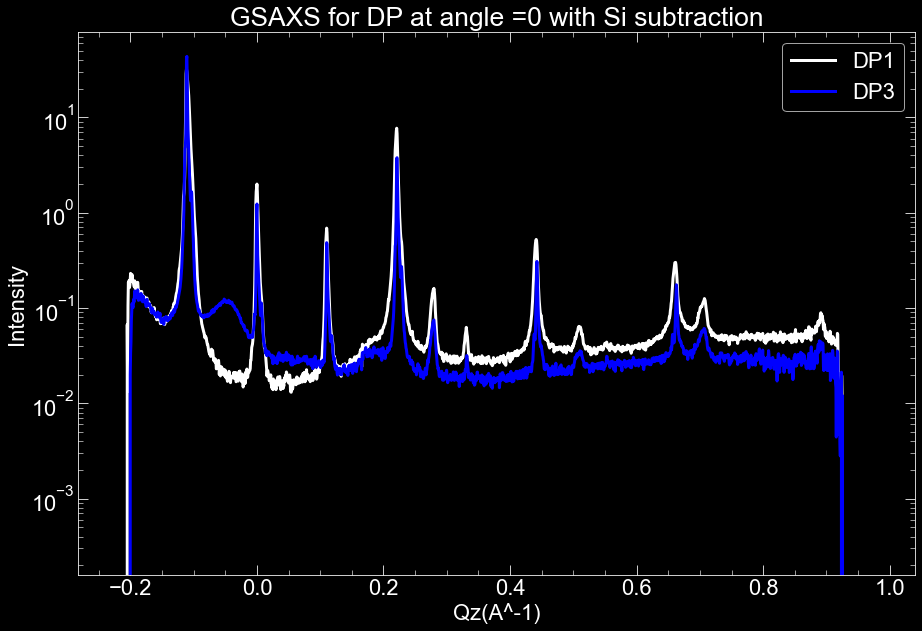

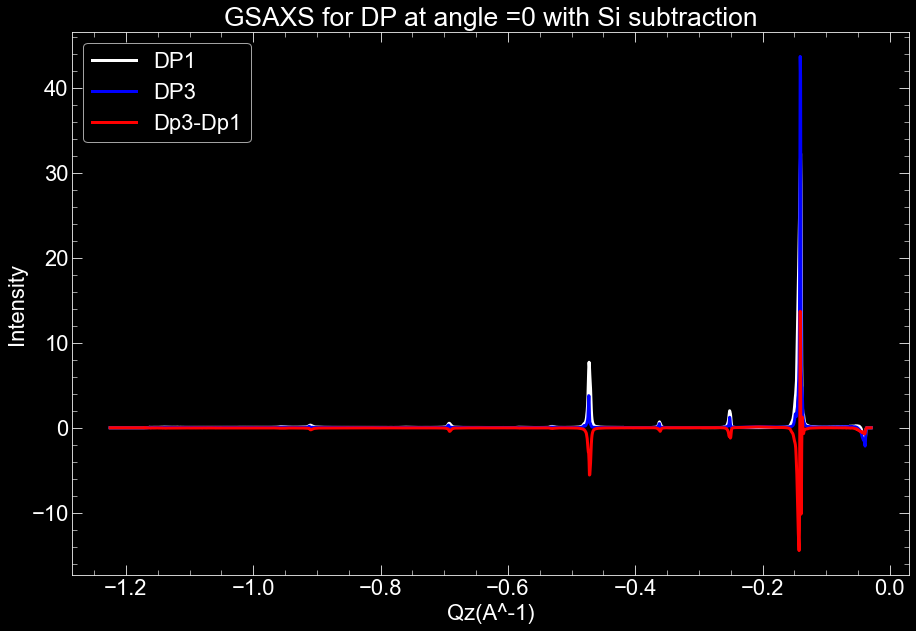

In [40]:
#at angle 0
qz_int(data_DP_0,'SSi_00_00556_00001.dat', angle=0)
qz_sub(data_DP_0,'SSi_00_00556_00001.dat', angle=0)

#data_DP_0_ws=['SDP1_00_00454_00001.dat','SDP3_00_00449_00001.dat','SSi_00_00556_00001.dat']
#qz_int_ws(data_DP_0_ws, angle=0)

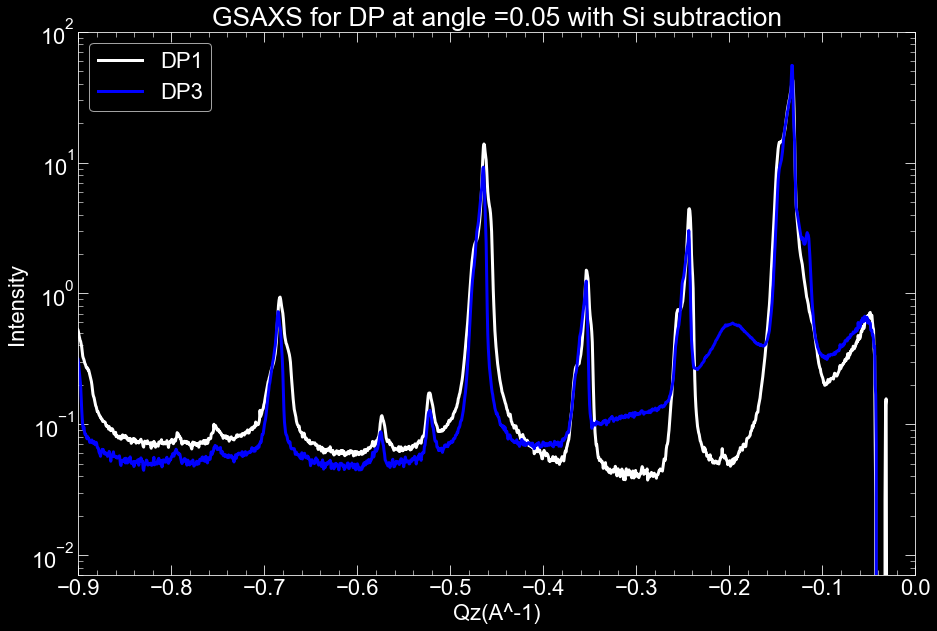

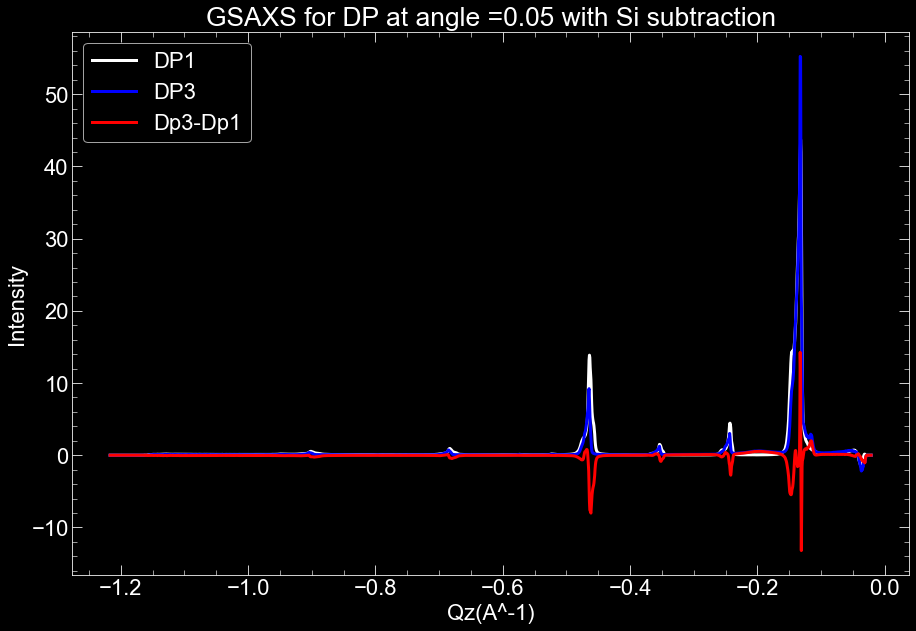

In [109]:
#at angle 0.05
qz_int(data_DP_005, 'SSi_05_00557_00001.dat', angle=0.05)
qz_sub(data_DP_005, 'SSi_05_00557_00001.dat', angle=0.05)

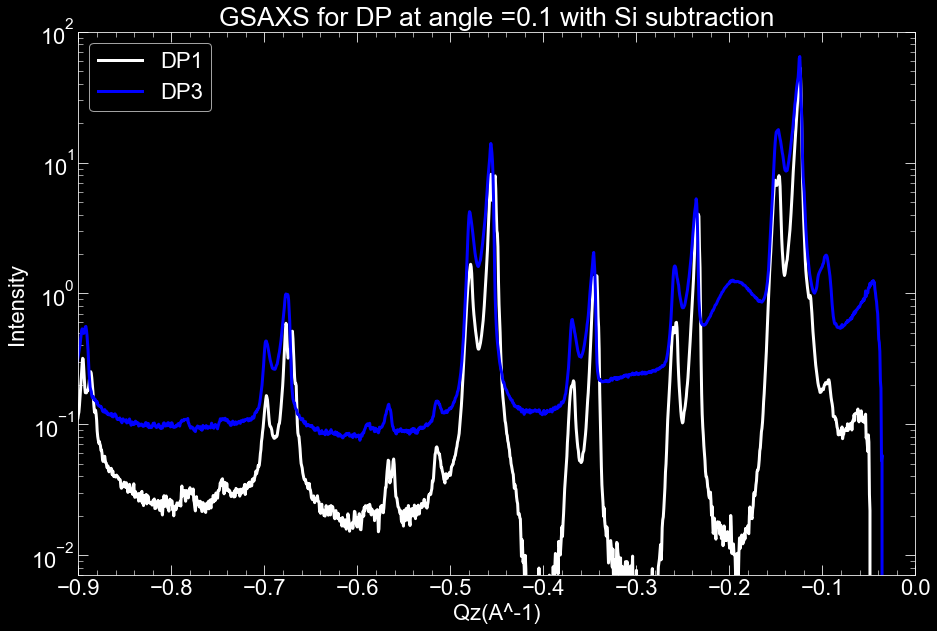

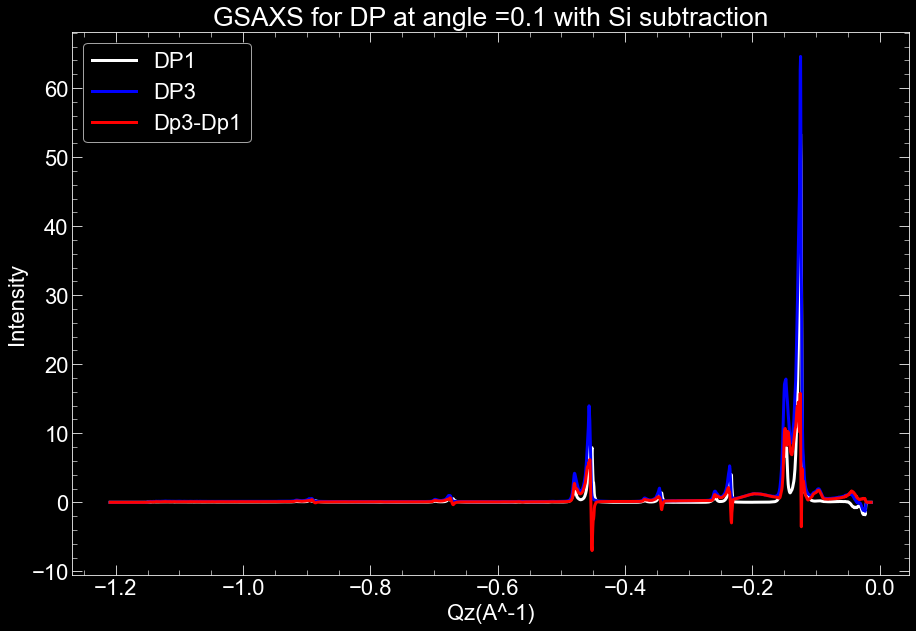

In [110]:
#at angle 0.1
qz_int(data_DP_01, 'SSi_10_00558_00001.dat', angle=0.1)
qz_sub(data_DP_01, 'SSi_10_00558_00001.dat', angle=0.1)

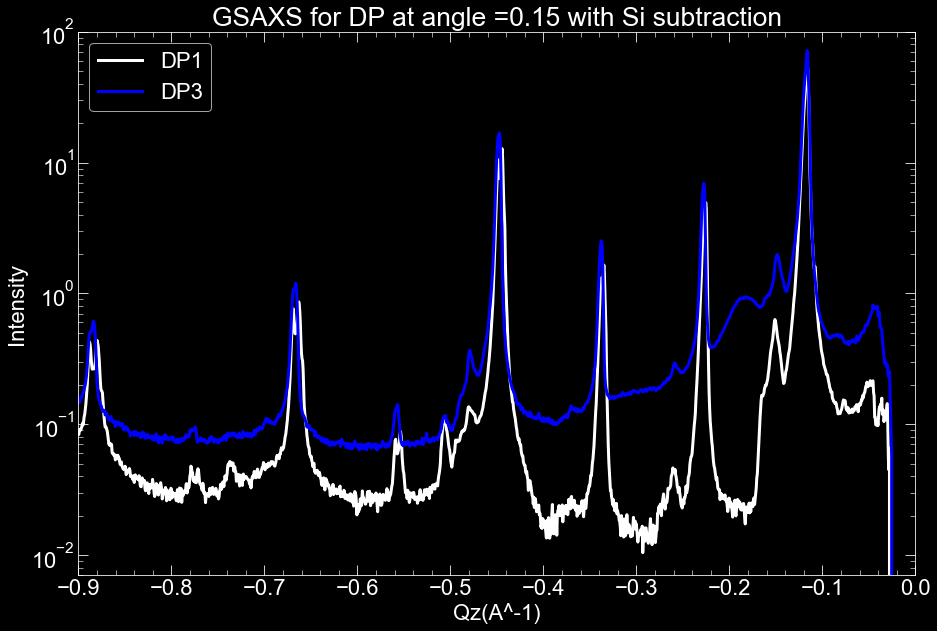

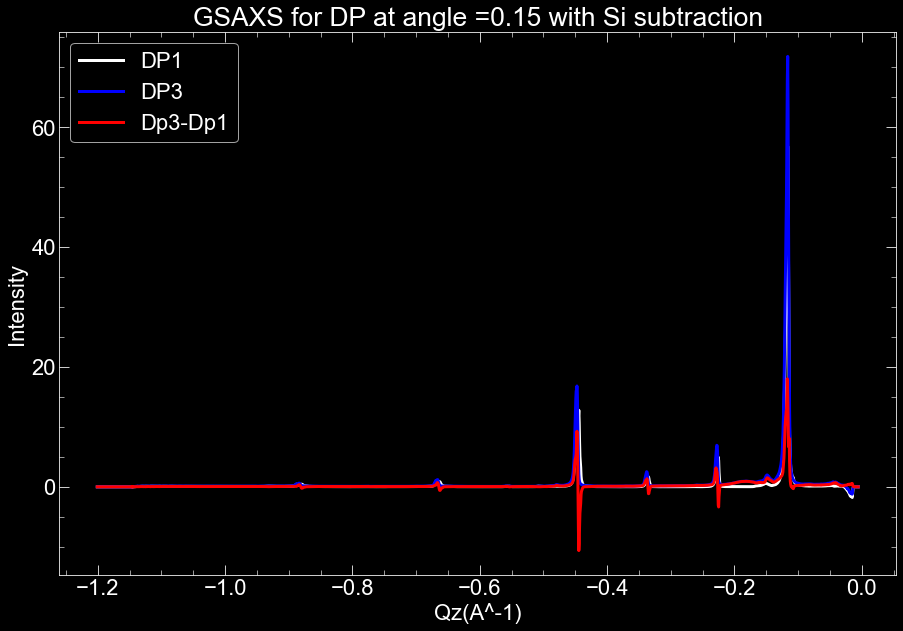

In [111]:
#at angle 0.15
qz_int(data_DP_015, 'SSi_15_00559_00001.dat', angle=0.15)
qz_sub(data_DP_015, 'SSi_15_00559_00001.dat', angle=0.15)

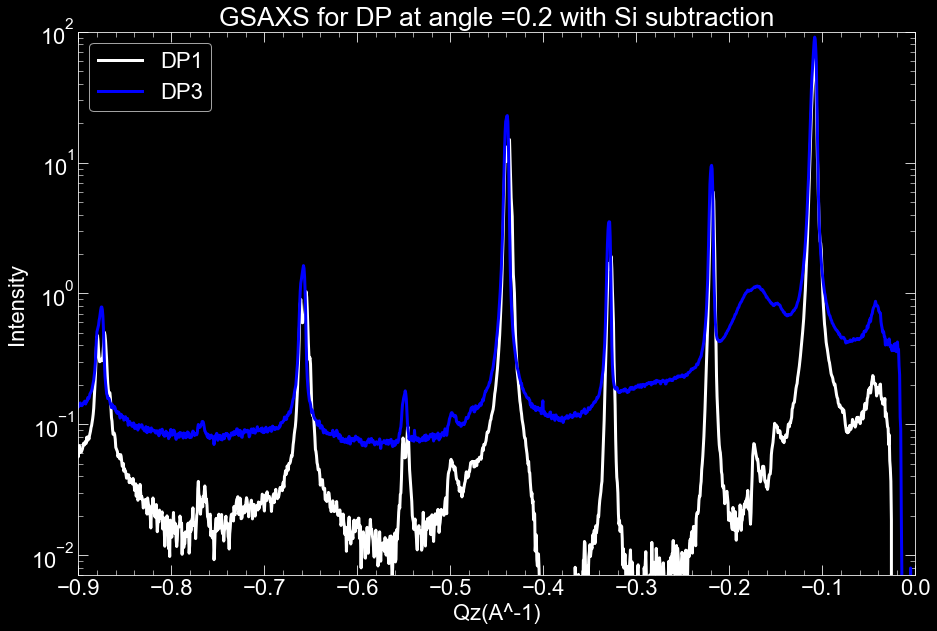

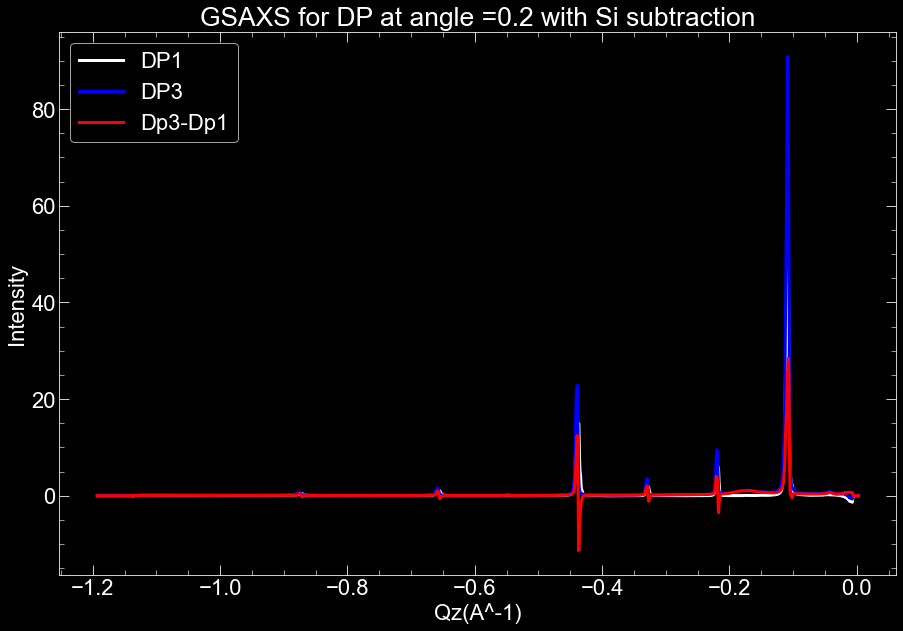

In [112]:
#at angle 0.2
qz_int(data_DP_02, 'SSi_20_00560_00001.dat', angle=0.2)
qz_sub(data_DP_02, 'SSi_20_00560_00001.dat', angle=0.2)

In [113]:
#P 
#P1: 40 µl miliQ water + 0.7 mg P19015 + 0.37 mg DPPC
#P2: 40 µl miliQ water + 0.7 mg P19015 + 0.37 mg DPPC + 0.0003 mg AuNPs
#P3: 40 µl miliQ water + 0.7 mg P19015 + 0.37 mg DPPC + 0.003 mg AuNPs

In [ ]:
#data_P_0=['SP1_00_00466_00001.dat','SP3_00_00449_00001.dat']

#qz_int(data_P_0, 'SSi_00_00556_00001.dat', angle=0)

In [ ]:
data_P_005=['SP1_05_00472_00001.dat','SP2_05_00477_00001.dat','SP3_05_00487_00001.dat']

qz_int(data_P_005, 'SSi_05_00557_00001.dat', angle=0.05)

In [ ]:
data_P_01=['SP1_10_00473_00001.dat','SP2_10_00478_00001.dat','SP3_10_00488_00001.dat']

qz_int(data_P_01, 'SSi_10_00558_00001.dat', angle=0.1)

In [ ]:
data_P_015=['SP1_15_00474_00001.dat','SP2_15_00479_00001.dat','SP3_15_00489_00001.dat']

qz_int(data_P_015, 'SSi_15_00559_00001.dat', angle=0.15)

In [ ]:
data_P_02=['SP1_20_00475_00001.dat','SP2_20_00480_00001.dat','SP3_20_00490_00001.dat']

qz_int(data_P_02, 'SSi_20_00560_00001.dat', angle=0.2)

In [ ]:
#CH 
#Ch1: 40 µl miliQ water + 1 mg DPPC + 1 mg DOPC + 0.17 mg Chol
#Ch2: 40 µl miliQ water + 1 mg DPPC + 1 mg DOPC + 0.17 mg Chol + 0.0013 mg AuNPs
#Ch3: 40 µl miliQ water + 1 mg DPPC + 1 mg DOPC + 0.17 mg Chol + 0.0066 mg AuNPs
#Ch4: 40 µl miliQ water + 1 mg DPPC + 1 mg DOPC + 0.17 mg Chol + 0.0132 mg AuNPs
#Ch5: 40 µl miliQ water + 1 mg DPPC + 1 mg DOPC + 0.17 mg Chol + 0.0264 mg AuNPs

In [ ]:
data_Ch_0=['SCh1_00_00496_00001.dat','SCh2_00_00511_00001.dat','SCh3_00_00536_00001.dat',
          'SCh5_00_00546_00001.dat']

qz_int(data_Ch_0, 'SSi_00_00556_00001.dat', angle=0)

In [ ]:
data_Ch_005=['SCh1_05_00497_00001.dat','SCh2_05_00517_00001.dat','SCh3_05_00527_00001.dat',
           'SCh5_05_00547_00001.dat']

qz_int(data_Ch_005, 'SSi_05_00557_00001.dat', angle=0.05)

In [ ]:
data_Ch_01=['SCh1_10_00498_00001.dat','SCh2_10_00518_00001.dat','SCh3_10_00528_00001.dat',
           'SCh5_10_00548_00001.dat']

qz_int(data_Ch_01, 'SSi_10_00558_00001.dat', angle=0.1)

In [ ]:
data_Ch_015=['SCh1_15_00499_00001.dat','SCh2_15_00519_00001.dat','SCh3_15_00529_00001.dat',
            'SCh5_15_00549_00001.dat']

qz_int(data_Ch_015, 'SSi_15_00559_00001.dat', angle=0.15)

In [ ]:
data_Ch_02=['SCh1_20_00500_00001.dat','SCh2_20_00520_00001.dat','SCh3_20_00530_00001.dat',
           'SCh5_20_00550_00001.dat']

qz_int(data_Ch_02, 'SSi_20_00560_00001.dat', angle=0.2)

In [ ]:
data_Ch_02_ws=['SCh1_20_00500_00001.dat','SCh2_20_00520_00001.dat','SCh3_20_00530_00001.dat',
           'SCh5_20_00550_00001.dat','SSi_20_00560_00001.dat']

qz_int_ws(data_Ch_02_ws, angle=0.2)

from igor pro files

In [114]:
igor_data_DP_0=['SDP1_00_00461_000_GI_VLp_-0.dat','SDP3_00_00449_000_GI_VLp_-0.dat']
igor_data_DP_005=['SDP1_05_00462_000_GI_VLp_-0.dat','SDP3_05_00450_000_GI_VLp_-0.dat']
igor_data_DP_01=['SDP1_10_00463_000_GI_VLp_-0.dat','SDP3_10_00451_000_GI_VLp_-0.dat']
igor_data_DP_015=['SDP1_15_00464_000_GI_VLp_-0.dat','SDP3_15_00452_000_GI_VLp_-0.dat']
igor_data_DP_02=['SDP1_20_00465_000_GI_VLp_-0.dat','SDP3_20_00453_000_GI_VLp_-0.dat']


In [115]:
sam=np.genfromtxt('SDP1_20_00465_000_GI_VLp_-0.dat', delimiter='\t', skip_header=42)
sam.shape

(1658, 6)

In [116]:
#without subtracting si
def qz_int_ws1(data, angle):
    all_samples=[]
    for sample in data:
        samp=np.genfromtxt(sample, delimiter='\t', skip_header=42)
        all_samples.append(samp)
    all_samples=np.array(all_samples)        #size of sample need to be same
    
    qz =all_samples[:,:,3]
    
    I=all_samples[:,:,4]   
    
    color=['red','white','green','blue','gray','yellow']
    plt.style.use('dark_background')
    fig, ax= plt.subplots(figsize=(15,10))
    ax.set(ylabel='Intensity', xlabel='Qz(A^-1)')
    for i in range(len(data)):
        ax.plot(qz[i,:],I[i,:], color=color[i],linewidth=3,label=data[i][1:4])
    ax.legend()
    #ax.set_xlim([-0.8, -0.18])
    #ax.set_ylim([0.007, 100])
    ax.set_yscale('log')
    figname=data[1][1:3]
    plt.title('GSAXS for ' + str(figname) +' at angle =' +str(angle)+ ' without Si subtraction')
    #return plt.savefig(figname)
    plt.show()

In [117]:
#substracting DP1 and Dp3
def qz_sub1(data, angle):

    samples=[]
    for sample in data:
        sam=np.genfromtxt(sample, delimiter='\t', skip_header=42)
        samples.append(sam)
    samples=np.array(samples)
    
    qz = samples[:,:,3]
    
    I=samples[:,:,4]
    
    qs=qz[1,:]
    Is=I[1,:]-I[0,:]
    
    color=['white','blue','green','gray','yellow', 'purple']
    plt.style.use('dark_background')
    fig, ax= plt.subplots(figsize=(15,10))
    ax.set(ylabel='Intensity', xlabel='Qz(A^-1)')
    for i in range(len(data)):
        ax.plot(qz[i,:],I[i,:], color=color[i],linewidth=3,label=data[i][1:4])
    ax.plot(qs, Is, color='red',linewidth=3,label='Dp3-Dp1')
    ax.legend()
    #ax.set_xlim([-0.8, -0.18])
    #ax.set_ylim([0.007, 100])
    #ax.set_yscale('log')
    figname=data[1][1:3]
    plt.title('GSAXS for ' + str(figname) +' at angle =' +str(angle)+ ' with Si subtraction')
    #return plt.savefig(figname)
    plt.show() 

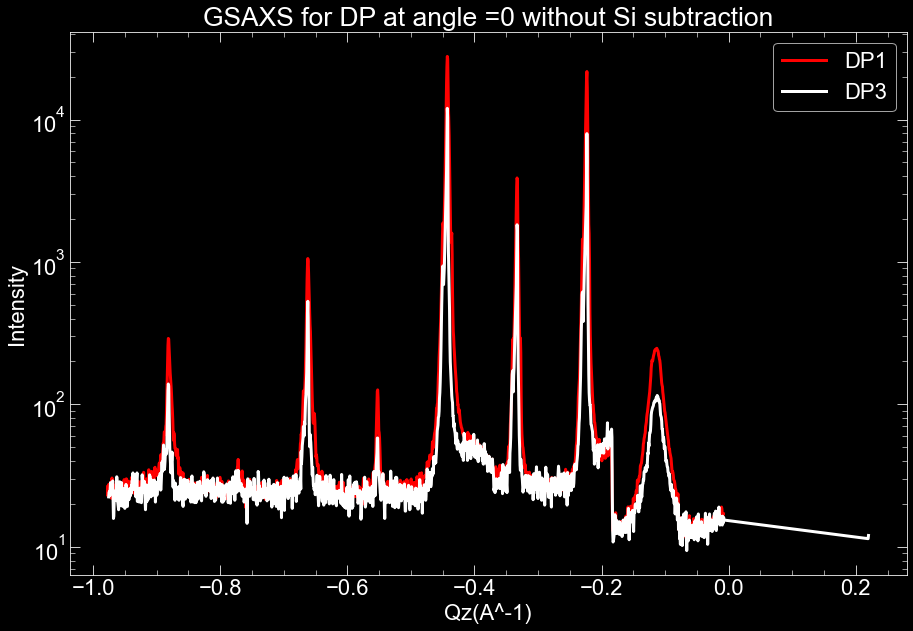

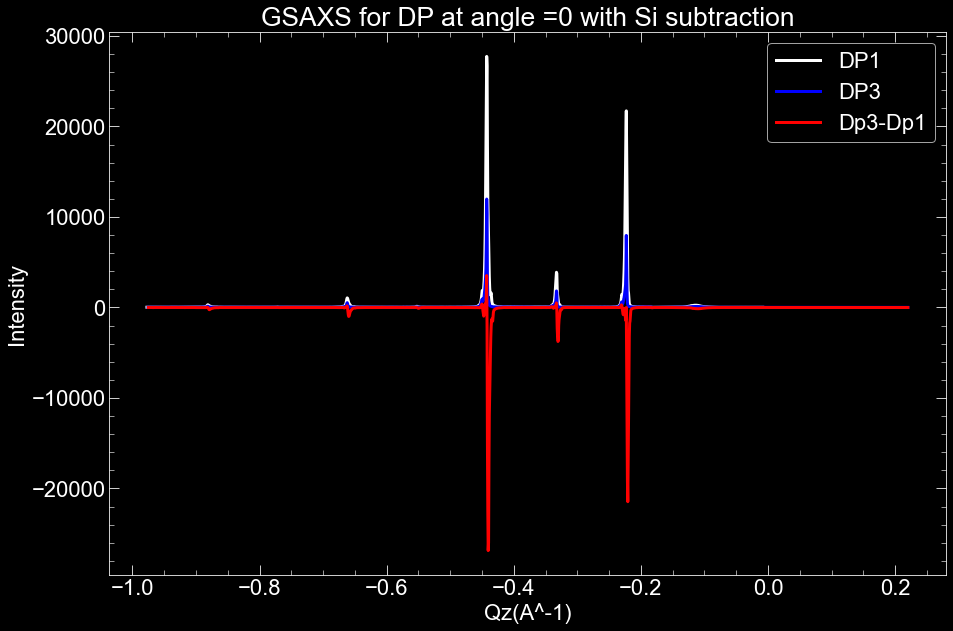

In [118]:
igor_data_DP_0=['SDP1_00_00461_000_GI_VLp_-0.dat','SDP3_00_00449_000_GI_VLp_-0.dat']
qz_int_ws1(igor_data_DP_0, 0)
qz_sub1(igor_data_DP_0, 0)

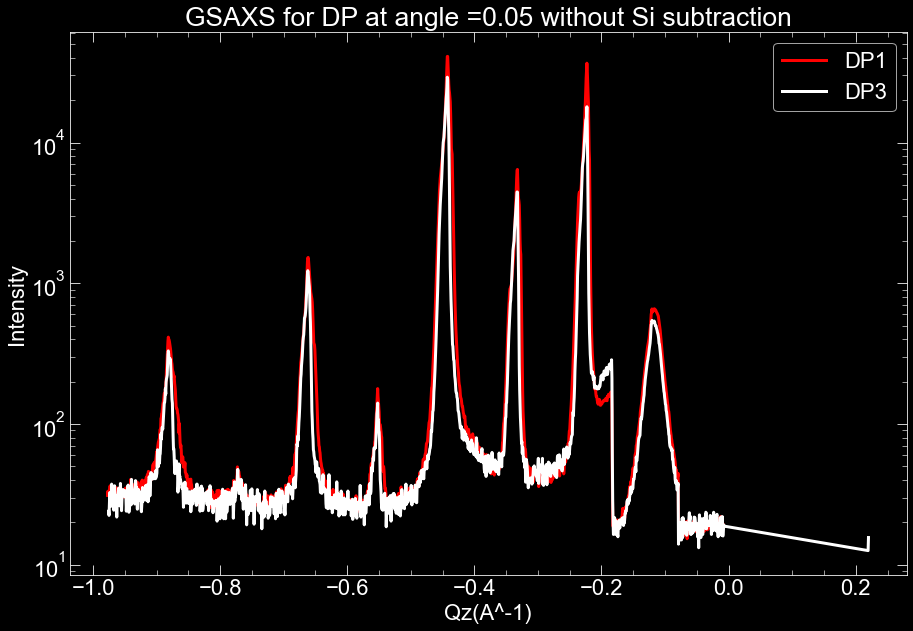

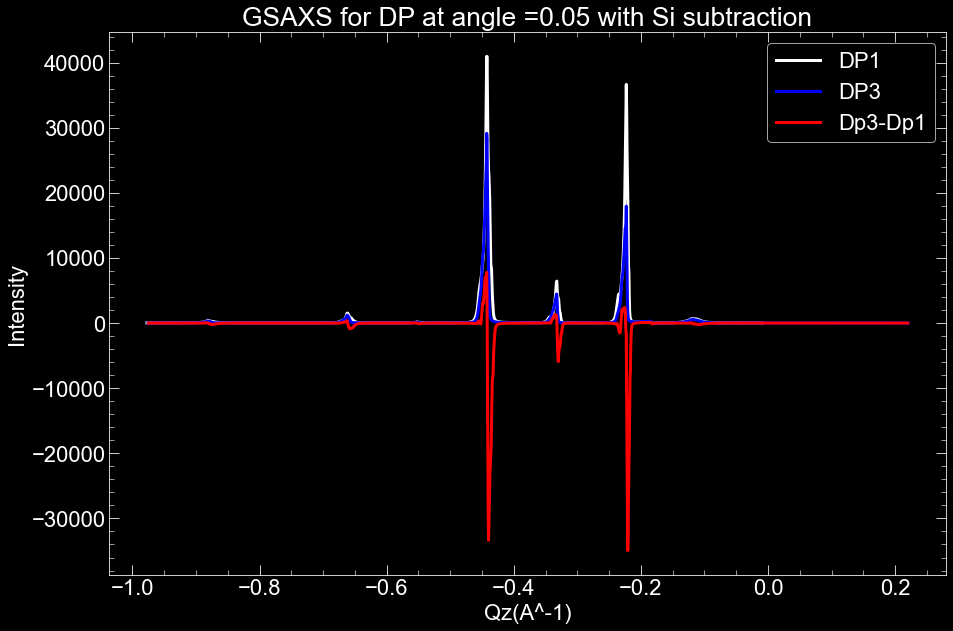

In [119]:
igor_data_DP_005=['SDP1_05_00462_000_GI_VLp_-0.dat','SDP3_05_00450_000_GI_VLp_-0.dat']
qz_int_ws1(igor_data_DP_005, 0.05)
qz_sub1(igor_data_DP_005, 0.05)

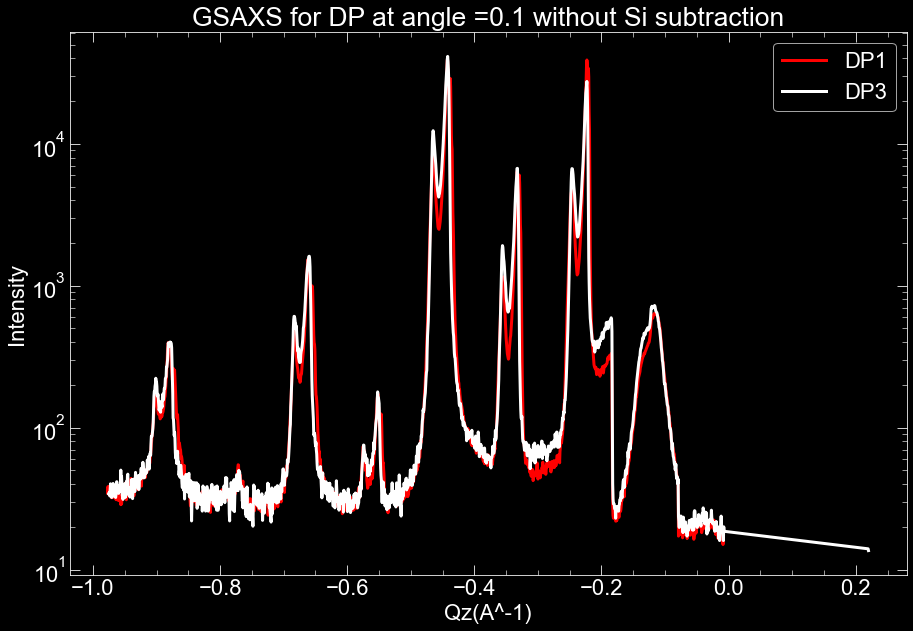

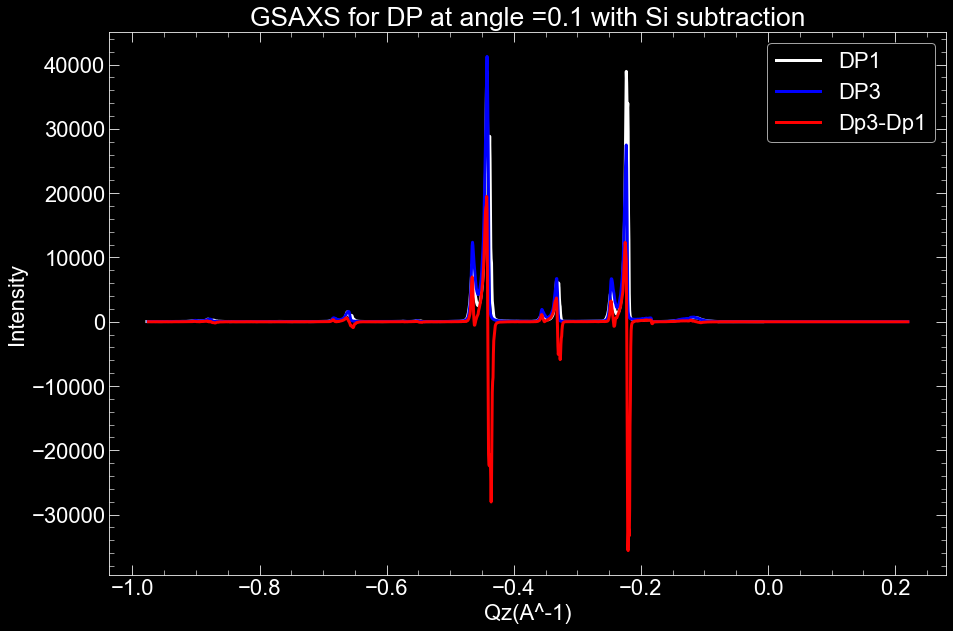

In [120]:
igor_data_DP_01=['SDP1_10_00463_000_GI_VLp_-0.dat','SDP3_10_00451_000_GI_VLp_-0.dat']
qz_int_ws1(igor_data_DP_01, 0.1)
qz_sub1(igor_data_DP_01, 0.1)

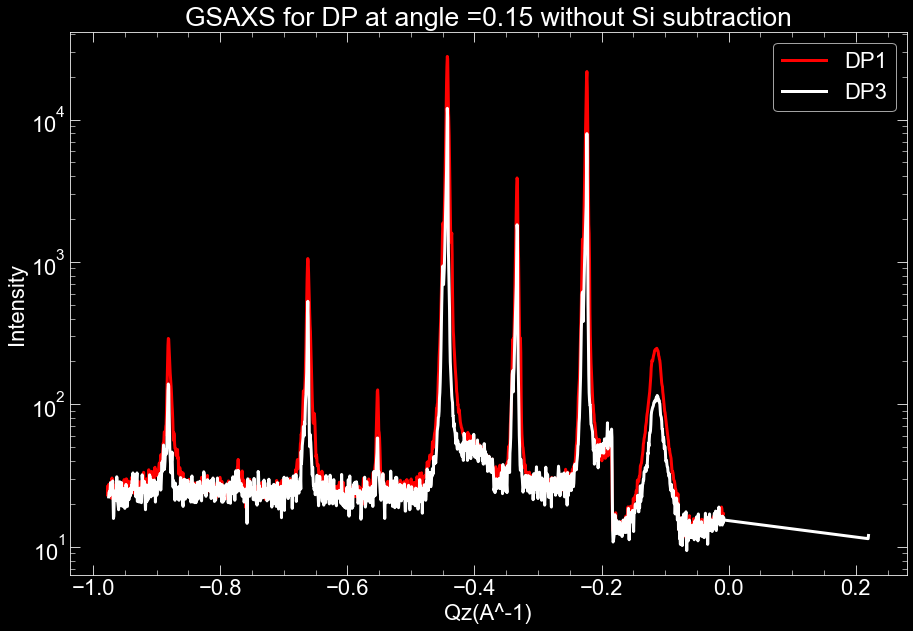

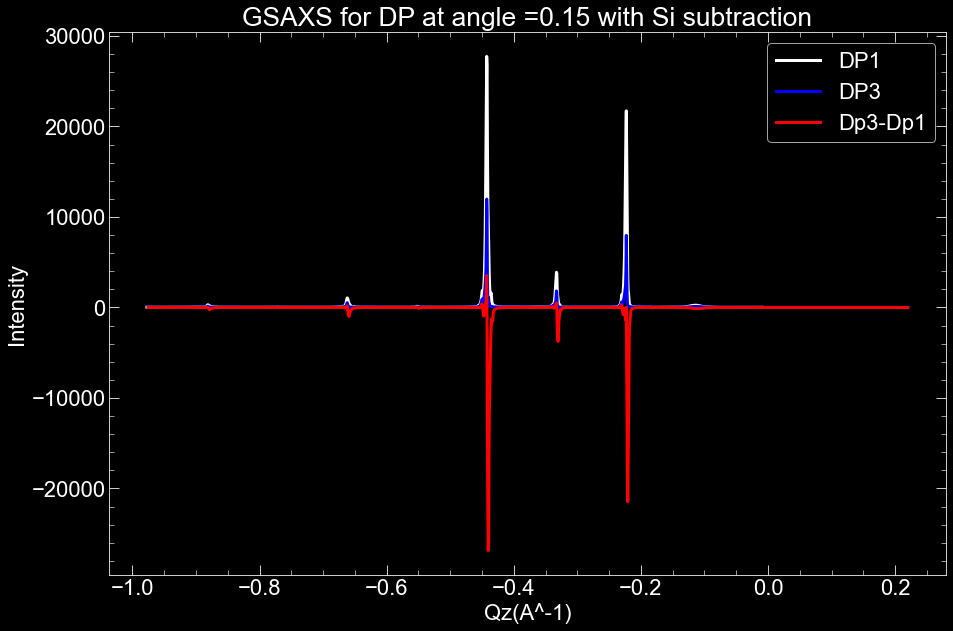

In [121]:
igor_data_DP_015=['SDP1_15_00464_000_GI_VLp_-0.dat','SDP3_15_00452_000_GI_VLp_-0.dat']
qz_int_ws1(igor_data_DP_0, 0.15)
qz_sub1(igor_data_DP_0, 0.15)

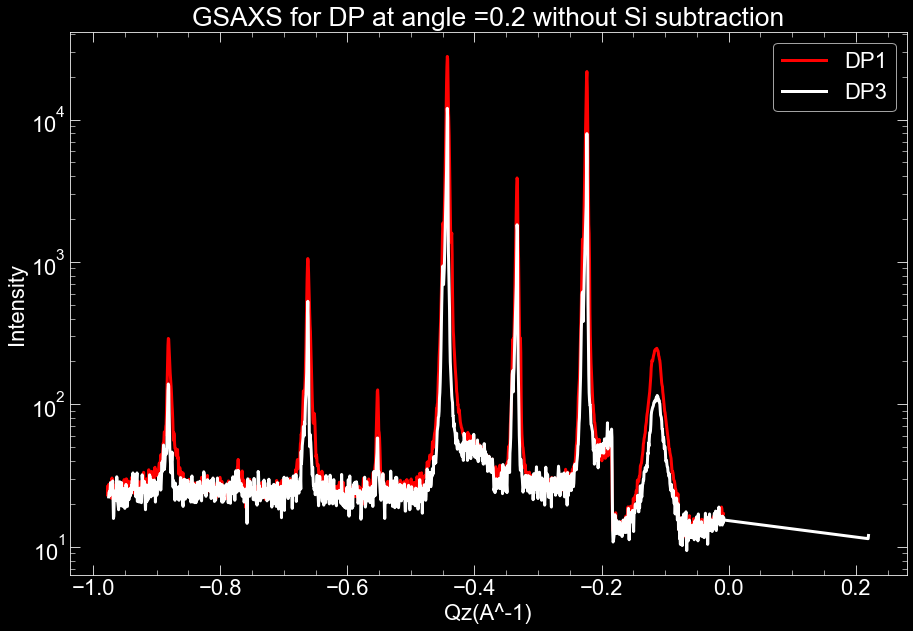

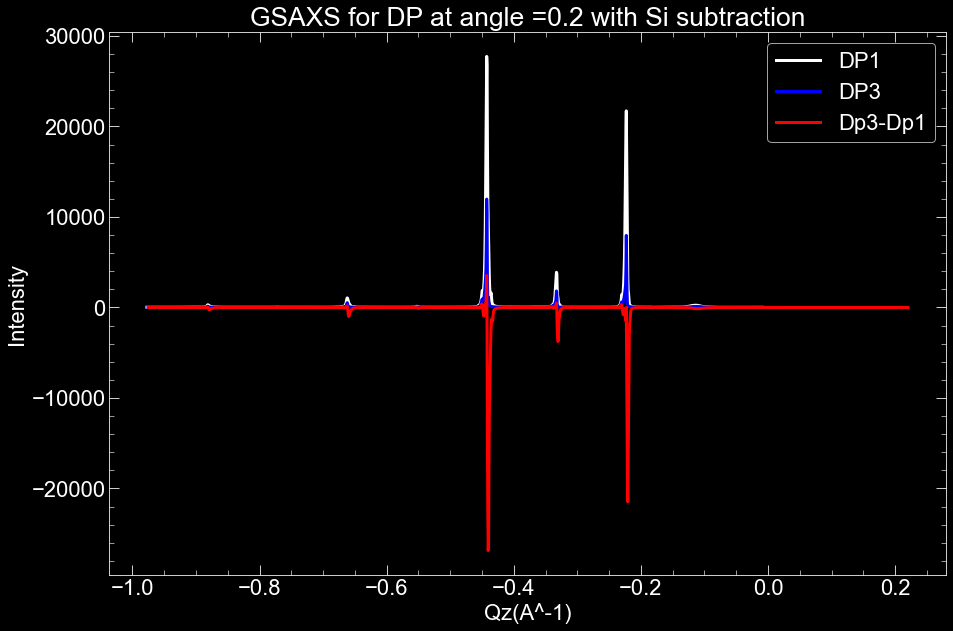

In [122]:
igor_data_DP_02=['SDP1_20_00465_000_GI_VLp_-0.dat','SDP3_20_00453_000_GI_VLp_-0.dat']
qz_int_ws1(igor_data_DP_0, 0.2)
qz_sub1(igor_data_DP_0, 0.2)

In [7]:
#using bokeh to plot in tab
#making a dictionary for all sample in a same group with same angle i.e Ch1-5 with same angle

igor_files=Path.cwd()/'Gsaxs/Igor_pro'
#igor_files=Path.cwd()
def igor_folder(name):
    group={}
    for file in igor_files.glob(name):
        sample=np.genfromtxt(file, delimiter='\t', skip_header=42)
        name=file.name[1:8]
        group[name]=sample
    return OrderedDict(sorted(group.items()))
    

In [8]:
igor_folder('SDP*_05_*.dat')

OrderedDict([('DP1_05_',
              array([[        nan,         nan,         nan,         nan,         nan,
                              nan],
                     [-0.97856593, -0.        , -0.        , -0.97711104, 31.049999  ,
                       3.099395  ],
                     [-0.97798502, -0.        , -0.        , -0.9765327 , 33.299999  ,
                       3.6674242 ],
                     ...,
                     [ 0.21946675, -0.        , -0.        ,  0.21945308, 12.45      ,
                       1.493737  ],
                     [ 0.22005486, -0.        , -0.        ,  0.2200411 , 12.7       ,
                       2.4199691 ],
                     [ 0.220643  , -0.        , -0.        ,  0.2206291 , 13.95      ,
                       1.8907671 ]])),
             ('DP3_05_',
              array([[-0.97682315, -0.        , -0.        , -0.97537595, 24.        ,
                       2.        ],
                     [-0.97624218, -0.        , -0.        ,

In [9]:
def tab_plot(data): #angle1=data at angle 0 and so on

    angle1= igor_folder(data[0])
    angle2= igor_folder(data[1])
    angle3= igor_folder(data[2])
    angle4= igor_folder(data[3])
    angle5= igor_folder(data[4])
    
    data=[angle1, angle2, angle3, angle4, angle5]
    
    an=['angle=0','angle=0.05','angle=0.1','angle=0.15','angle=0.2']
    tabs=[]
    for angl, i in zip(data, range(5)):
        f=figure(y_axis_type="log", y_axis_label=' Intensity', x_axis_label='Qz')
        for k, color in zip(angl,Category10[10]):
            d=angl[k]
            x=d[:,3]
            y=d[:,4]
            f.line(x,y, color=color,line_width=3,legend_label=k, alpha=0.9,
                     hover_color='purple', hover_alpha=0.8)
        hover = HoverTool(tooltips=[ ('Q', '@x'), ('I', '@y')], mode='mouse')
        f.add_tools(hover)
        tab = Panel(child=f, title=an[i])
        tabs.append(tab)
    layout = Tabs(tabs=tabs)
    show(layout)

In [10]:
def tab_plot_sub(data): #angle1=data at angle 0 and so on

    angle1= igor_folder(data[0])
    angle2= igor_folder(data[1])
    angle3= igor_folder(data[2])
    angle4= igor_folder(data[3])
    angle5= igor_folder(data[4])
    
    data=[angle1, angle2, angle3, angle4, angle5]
    
    an=['angle=0','angle=0.05','angle=0.1','angle=0.15','angle=0.2']
    tabs=[]
    for angl, i in zip(data, range(5)):
        f=figure(y_axis_label=' Intensity', x_axis_label='Qz')
        X=[]
        Y=[]
        for k, color in zip(angl,Category10[10]):
            d=angl[k]
            x=d[:,3]
            y=d[:,4]     
            f.line(x,y, color=color,line_width=3,legend_label=k, alpha=0.9,
                     hover_color='purple', hover_alpha=0.8)
            X.append(x)
            Y.append(y)
        xs=X[0][:1659]
        ys=Y[1]-Y[0][:1659]
        f.line(xs,ys, color='red',line_width=3,legend_label='Subs', alpha=0.9,
                     hover_color='black', hover_alpha=0.8)
        hover = HoverTool(tooltips=[ ('Q', '@x'), ('I', '@y')], mode='mouse')
        f.add_tools(hover)
        tab = Panel(child=f, title=an[i])
        tabs.append(tab)
    layout = Tabs(tabs=tabs)
    show(layout)

In [11]:
DP=['SDP*_00_*.dat','SDP*_05_*.dat','SDP*_10_*.dat','SDP*_15_*.dat','SDP*_20_*.dat']

In [12]:
tab_plot(DP)
tab_plot_sub(DP)

In [ ]:
Ch=['SCh*_00_*.dat','SCh*_05_*.dat','SCh*_10_*.dat','SCh*_15_*.dat','SCh*_20_*.dat']
P=['SP*_00_*.dat','SP*_05_*.dat','SP*_10_*.dat','SP*_15_*.dat','SP*_20_*.dat']

In [ ]:
tab_plot(data=Ch)

In [ ]:
tab_plot(data=P)

def plot(angle1,angle2,angle3,angle4,angle5): #angle1=data at angle 0 and so on

    angle1= igor_folder(angle1)
    angle2= igor_folder(angle2)
    angle3= igor_folder(angle3)
    angle4= igor_folder(angle4)
    angle5= igor_folder(angle5)
    
    f1 = figure(title='angle=0', y_axis_type="log", x_range=[-0.8, -0.18], y_axis_label=' Intensity', x_axis_label='qz')
    for k,color in zip(angle1,Category10[10]):
        ang1 = angle1[k]
        f1.line(ang1[:,3],ang1[:,4], color=color,line_width=2,legend_label=k)
    show(f1)
    
    f2 = figure(title='angle=0.05', y_axis_type="log",x_range=[-0.8, -0.18],  y_axis_label=' Intensity', x_axis_label='qz')
    for k,color in zip(angle2,Category10[10]):
        ang2 = angle2[k]
        f2.line(ang2[:,3],ang2[:,4], color=color,line_width=2,legend_label=k)
    show(f2)
    
    f3 = figure(title='angle=0.1', y_axis_type="log",x_range=[-0.8, -0.18],  y_axis_label=' Intensity', x_axis_label='qz')
    for k,color in zip(angle3,Category10[10]):
        ang3 = angle3[k]
        f3.line(ang3[:,3],ang3[:,4], color=color,line_width=2,legend_label=k)
    show(f3)
    
    f4 = figure(title='angle=0.15', y_axis_type="log",x_range=[-0.8, -0.18],  y_axis_label=' Intensity', x_axis_label='qz')
    for k,color in zip(angle4,Category10[10]):
        ang4 = angle4[k]
        f4.line(ang4[:,3],ang4[:,4], color=color,line_width=2,legend_label=k)
    show(f4)
    
    f5 = figure(title='angle=0.2', y_axis_type="log", x_range=[-0.8, -0.18], y_axis_label=' Intensity', x_axis_label='qz')
    for k,color in zip(angle5,Category10[10]):
        ang5 = angle5[k]
        f5.line(ang5[:,3],ang5[:,4], color=color,line_width=2,legend_label=k)
    show(f5)
    

In [ ]:
#For CH group
#plot('SCh*_00_*.dat','SCh*_05_*.dat','SCh*_10_*.dat','SCh*_15_*.dat','SCh*_20_*.dat')

In [ ]:
#For P group
#plot('SP*_00_*.dat','SP*_05_*.dat','SP*_10_*.dat','SP*_15_*.dat','SP*_20_*.dat')

In [ ]:
#For DP group
#plot('SDP*_00_*.dat','SDP*_05_*.dat','SDP*_10_*.dat','SDP*_15_*.dat','SDP*_20_*.dat')

In [29]:
#to import multiple figures
# single figures without averaging
igor_2dfig=Path.cwd()/'Gsaxs/igor2021'

        
def process1(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = Image.open(filename)    #from PIL import Image
    #image = mpimg.imread(filename)
    #plt.figure()
    #plt.imshow(image1)
    display(image)

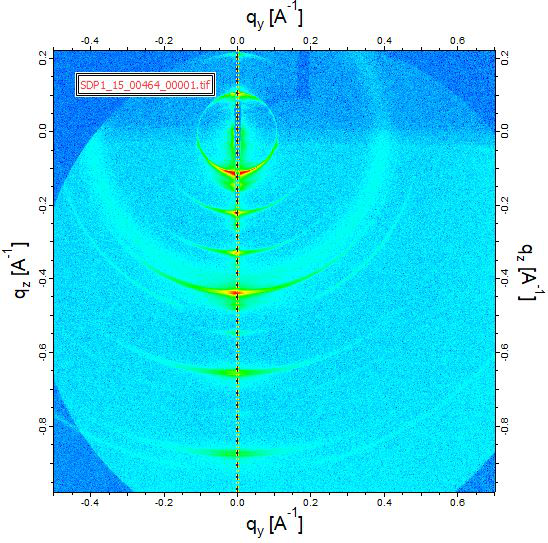

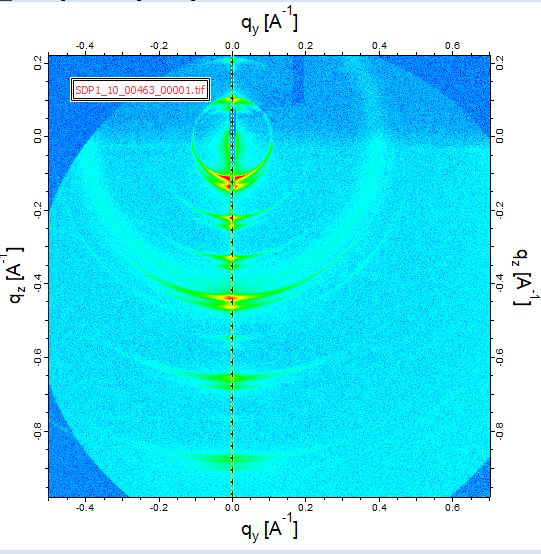

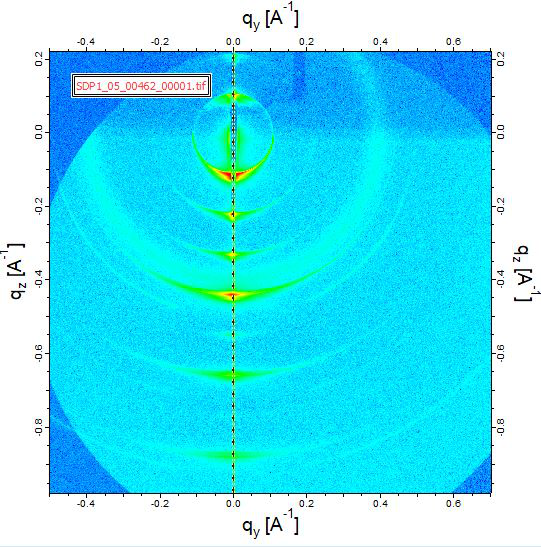

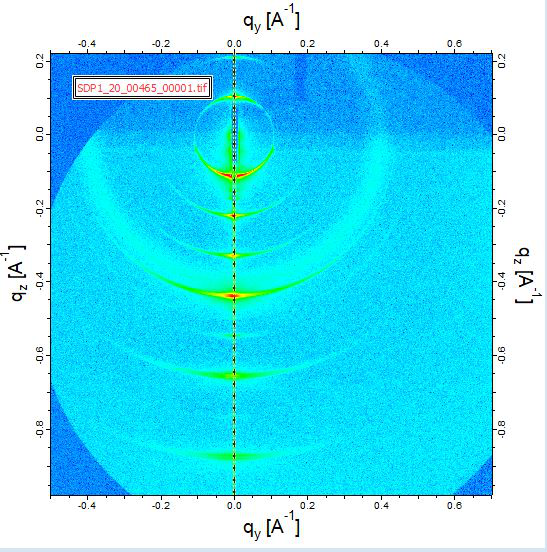

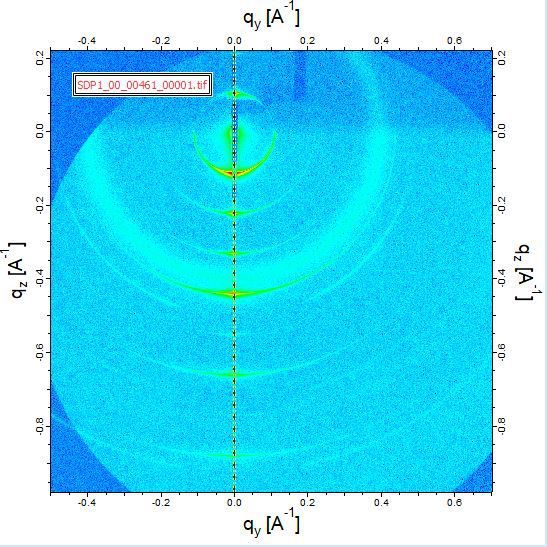

In [56]:
for file in igor_2dfig.glob('Dp1*.JPG'):
    process1(file)

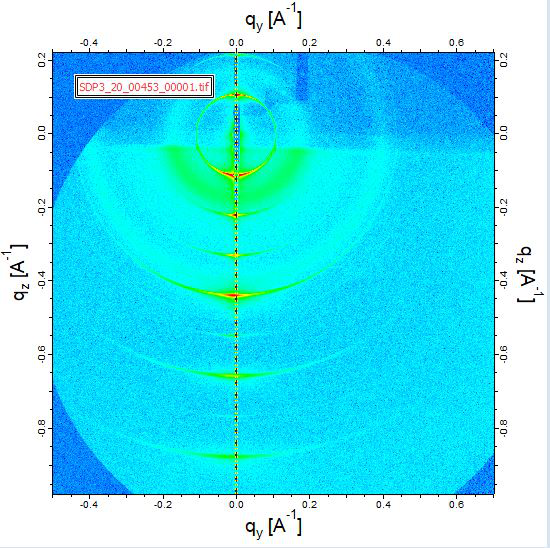

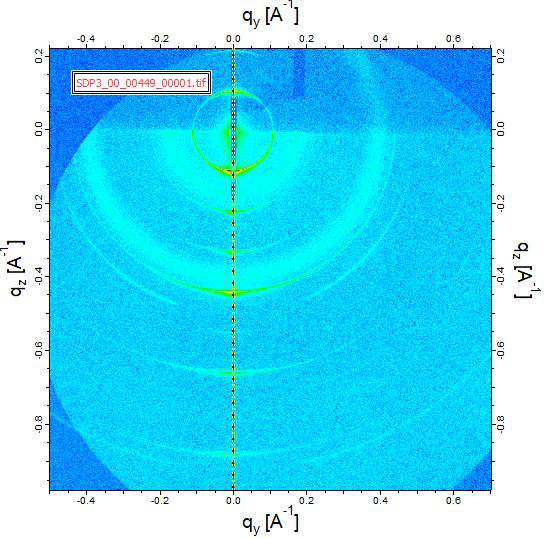

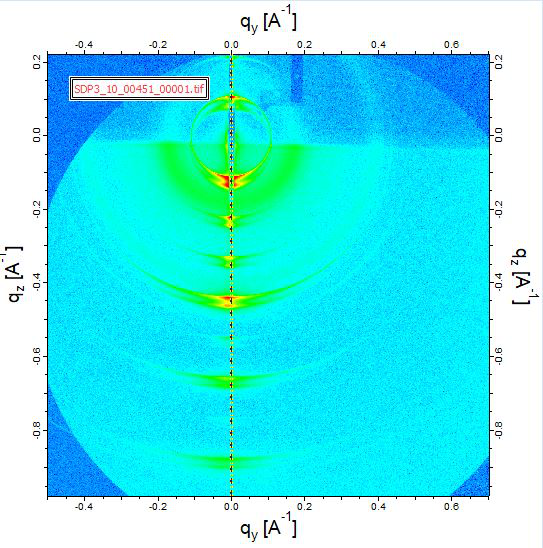

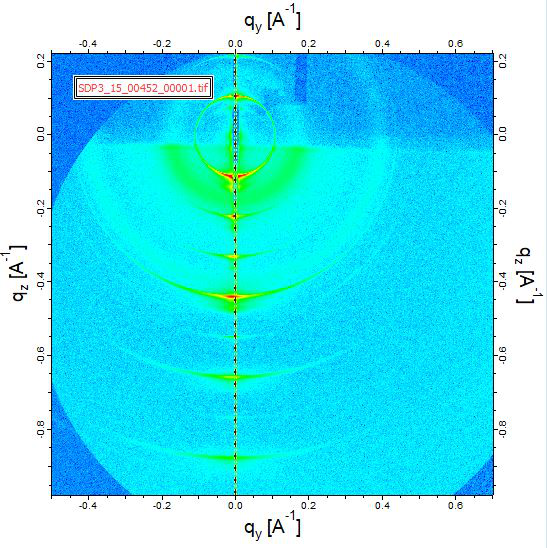

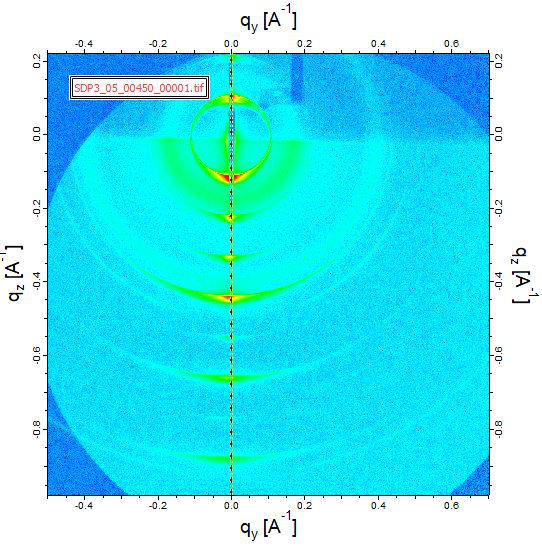

In [31]:
for file in igor_2dfig.glob('Dp3*.JPG'):
    process1(file)

In [ ]:
#averaging figures

In [75]:
#to import multiple figures

igor_2dfig=Path.cwd()/'Gsaxs/2D_figure'

        
def process(filename: str=None) -> None:
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image = Image.open(filename)    #from PIL import Image
    #image = mpimg.imread(filename)
    #plt.figure()
    #plt.imshow(image1)
    display(image)


In [77]:
#igor figure name
files=[]
for file in igor_2dfig.glob('*.png'):
    files.append(file)
files=np.sort(files)
Ch1=[files[i] for i in range(0,4)]
Ch2=[files[i] for i in range(4,9)]
Ch3=[files[i] for i in range(9,14)]
Ch5=[files[i] for i in range(14,19)]
Dp1=[files[i] for i in range(19,24)]
Dp3=[files[i] for i in range(24,29)]
P1=[files[i] for i in range(29,34)]
P2=[files[i] for i in range(34,39)]
P3=[files[i] for i in range(39,44)]

In [78]:
def igor_fig_plot(group_name):
    for file in group_name:
        process(file)

In [79]:
def igor_fig_plot1(group_name):
    tabs=[]
    an=['angle0.01', 'angle0.05', 'angle0.1', 'angle0.15', 'angle0.2']
    for file, i in zip(group_name, range(5)): 
        p = figure(x_range=(0,5), y_range=(0,5))
        #p.image(image=process(file))
        tab = Panel(child=p, title=an[i])
        tabs.append(tab)
    layout = Tabs(tabs=tabs)
    show(layout)

In [80]:
igor_fig_plot1(Dp1)    #change Ch1 to Ch2, Ch3,....Dp1, Dp2, Dp3...P1..

In [81]:
#more recent dp without averaging

In [82]:
#making a dictionary for all sample in a same group with same angle i.e Dp1-3 with same angle
igor_files=Path.cwd()/'Gsaxs/igor2021'
def igor_folder1(name):
    group={}
    for file in igor_files.glob(name):
        sample=np.genfromtxt(
            
            file, delimiter='\t', skip_header=42)
        name=file.name[0:6]
        group[name]=sample
    return OrderedDict(sorted(group.items()))

In [83]:
igor_folder1('DP*_00_*.dat')

OrderedDict([('DP3_00',
              array([[-0.97682315, -0.        , -0.        , -0.97541279, 22.4       ,
                       4.8270073 ],
                     [-0.97624218, -0.        , -0.        , -0.97483438, 24.        ,
                       4.6904159 ],
                     [-0.97566122, -0.        , -0.        , -0.97425592, 24.4       ,
                       3.3615472 ],
                     ...,
                     [ 0.21946675, -0.        , -0.        ,  0.21945132, 11.4       ,
                       2.1908903 ],
                     [ 0.22005486, -0.        , -0.        ,  0.22003932, 12.        ,
                       1.8708287 ],
                     [ 0.220643  , -0.        , -0.        ,  0.22062732, 13.        ,
                       2.9154758 ]]))])

In [84]:
def tab_plot1(data): #angle1=data at angle 0 and so on

    angle1= igor_folder1(data[0])
    angle2= igor_folder1(data[1])
    angle3= igor_folder1(data[2])
    angle4= igor_folder1(data[3])
    
    
    data=[angle1, angle2, angle3, angle4]
    
    an=['angle=0.05','angle=0.1','angle=0.15','angle=0.2']
    tabs=[]
    for angl, i in zip(data, range(5)):
        f=figure(y_axis_type="log", y_axis_label=' Intensity', x_axis_label='Qz')
        for k, color in zip(angl,Category10[10]):
            d=angl[k]
            x=d[:,3]
            y=d[:,4]
            f.line(x,y, color=color,line_width=3,legend_label=k, alpha=0.9,
                     hover_color='purple', hover_alpha=0.8)
        hover = HoverTool(tooltips=[ ('Q', '@x'), ('I', '@y')], mode='mouse')
        f.add_tools(hover)
        tab = Panel(child=f, title=an[i])
        tabs.append(tab)
    layout = Tabs(tabs=tabs)
    show(layout)

In [85]:
def tab_plot_sub1(data): #angle1=data at angle 0 and so on

    angle1= igor_folder1(data[0])
    angle2= igor_folder1(data[1])
    angle3= igor_folder1(data[2])
    angle4= igor_folder1(data[3])
  
    data=[angle1, angle2, angle3, angle4]
    
    an=['angle=0.05','angle=0.1','angle=0.15','angle=0.2']
    tabs=[]
    for angl, i in zip(data, range(5)):
        f=figure( y_axis_label=' Intensity', x_axis_label='Qz')
        X=[]
        Y=[]
        for k, color in zip(angl,Category10[10]):
            d=angl[k]
            x=d[:,3]
            y=d[:,4]
            X.append(x)
            Y.append(y)
            
            f.line(x,y, color=color,line_width=3,legend_label=k, alpha=0.9,
                     hover_color='purple', hover_alpha=0.8)
        xs=X[1]
        ys=Y[1]-Y[0][:2043]
        f.line(xs,ys, color='red',line_width=3,legend_label='Subs', alpha=0.9,
                     hover_color='black', hover_alpha=0.8)
        hover = HoverTool(tooltips=[ ('Q', '@x'), ('I', '@y')], mode='mouse')
        f.add_tools(hover)
        tab = Panel(child=f, title=an[i])
        tabs.append(tab)
    layout = Tabs(tabs=tabs)
    show(layout)

In [86]:
DP=['DP*_05_*.dat','DP*_10_*.dat','DP*_15_*.dat','DP*_20_*.dat']
tab_plot1(DP)
tab_plot_sub1(DP)